In [83]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

In [84]:
def Conv2D(image, filters, stride, padding):
    h, w, c = image.shape
    f, f, n_of_filters = filters.shape
    if padding == 'same':
        new_h = h // stride
        new_w = w // stride
    else:
        new_h = (h - f) // stride + 1
        new_w = (w - f) // stride + 1
    output_images = np.zeros((new_h, new_w, n_of_filters))
    for i in range(n_of_filters):
        for j in range(c):
            if padding == 'same':
                p = (f - 1) // 2
                padded_image = np.pad(image[:,:,j], ((p, p), (p, p)), mode='constant')
            else:
                padded_image = image[:,:,j]
            for k in range(0, new_h):
                for l in range(0, new_w):
                    roi = padded_image[(k*stride):(k*stride)+f, (l*stride):(l*stride)+f]
                    output_images[k, l, i] += np.sum(roi * filters[:,:,i])
    return output_images

In [85]:
def max_pooling(images, f):
    h, w, n_of_filters = images.shape
    new_h = h // f
    new_w = w // f
    output_image = np.zeros((new_h, new_w, n_of_filters))
    for i in range(n_of_filters):
        for k in range(0, new_h):
            for l in range(0, new_w):
                roi = images[(k*f):(k + 1)*f, (l*f):(l + 1)*f, i]
                output_image[k, l, i] += np.amax(roi)
    return output_image

In [86]:
#filters
bottom_sobel =    [[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]]
               
top_sobel =     [[1, 2, 1],
                 [0, 0, 0],
                 [-1,-2,-1]]

sharpening = [[0,-1,0],
              [-1,5,-1],
              [0,-1,0]]

weighted_averaging_3_3 = (1/16)*np.array([[1, 2, 1],
                                [2, 4, 2],
                                [1, 2, 1]])


robert_x = [[1, 0],
            [0, -1]]    

robert_y = [[0, +1],
            [-1, 0]] 

averaging_2x2 = (1/4)*np.array([[1, 1],
                       [1, 1]])


gaussian_5x5 = (1/273)*np.array([[1,4,7,4,1],
                        [4,16,26,16,4],
                        [7,26,41,26,7],
                        [4,16,26,16,4],
                        [1,4,7,4,1]])

averaging_5x5 = (1/25)*np.ones((5, 5))

first_layer_filters = [[[bottom_sobel[i][j], top_sobel[i][j], sharpening[i][j], weighted_averaging_3_3[i][j]]
                        for j in range(weighted_averaging_3_3.shape[1])] for i in range(weighted_averaging_3_3.shape[0])]
second_layer_filters = [[[robert_x[i][j], robert_y[i][j], averaging_2x2[i][j]]
                        for j in range(averaging_2x2.shape[1])] for i in range(averaging_2x2.shape[0])]
third_layer_filters = [[[gaussian_5x5[i][j], averaging_5x5[i][j]]
                        for j in range(averaging_5x5.shape[1])] for i in range(averaging_5x5.shape[0])]


In [87]:
image = cv2.imread('Sample Inputs/images/hinton.jpg')
image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
print(image.shape)
out1 = Conv2D(image, np.array(first_layer_filters), 1, 'same')
print(out1.shape)
out2 = Conv2D(out1, np.array(second_layer_filters), 2, 'same')
print(out2.shape)
out3 = Conv2D(out2, np.array(third_layer_filters), 1, 'valid')
print(out3.shape)
out3 = max_pooling(out3, 2)
print(out3.shape)

(352, 352, 3)
(352, 352, 4)
(176, 176, 3)
(172, 172, 2)
(86, 86, 2)


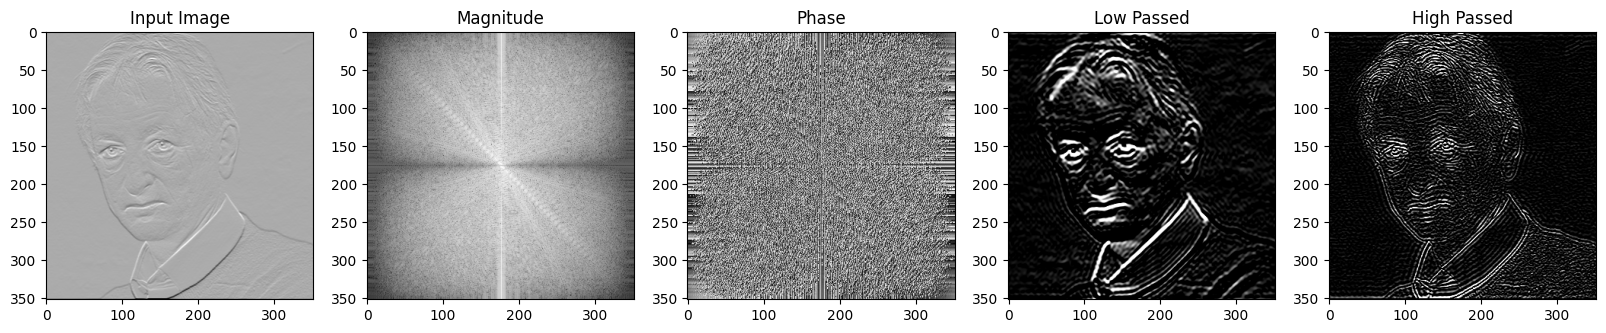

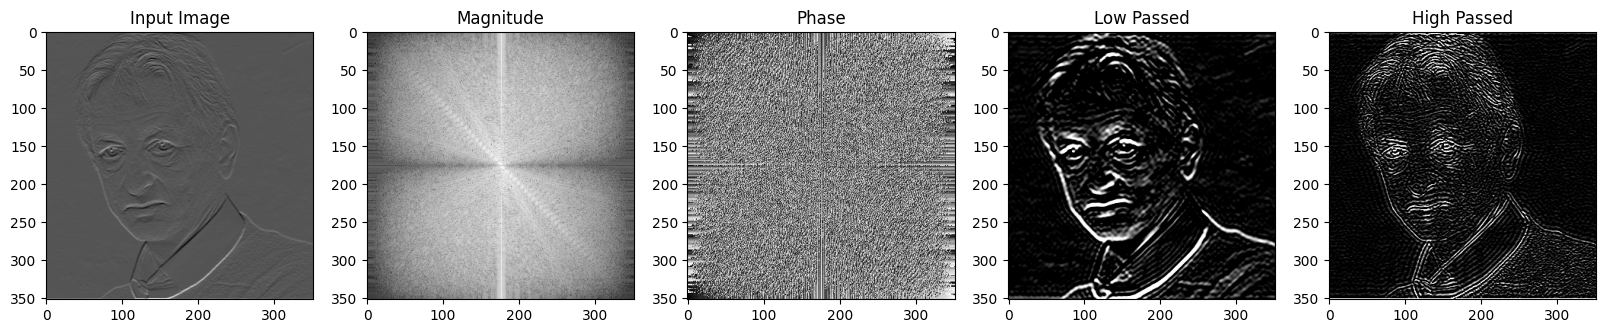

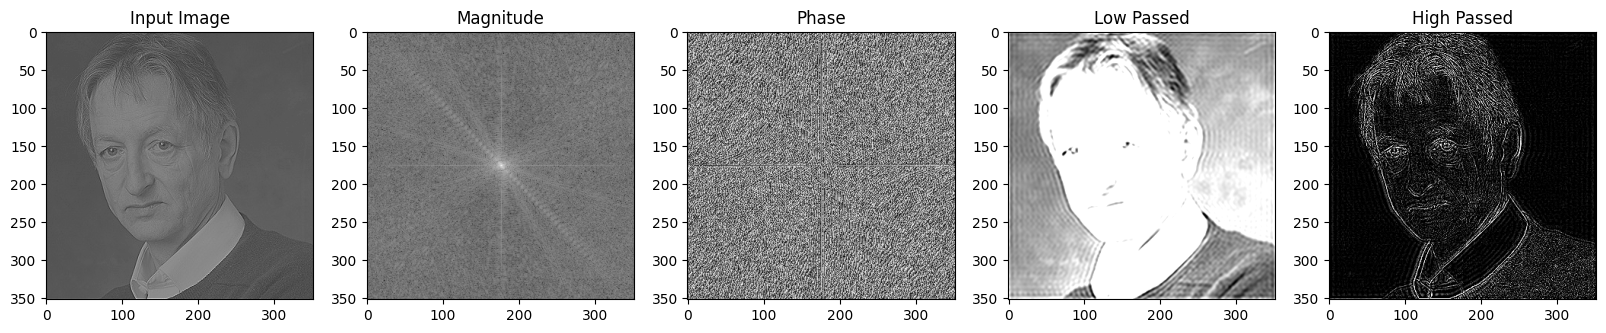

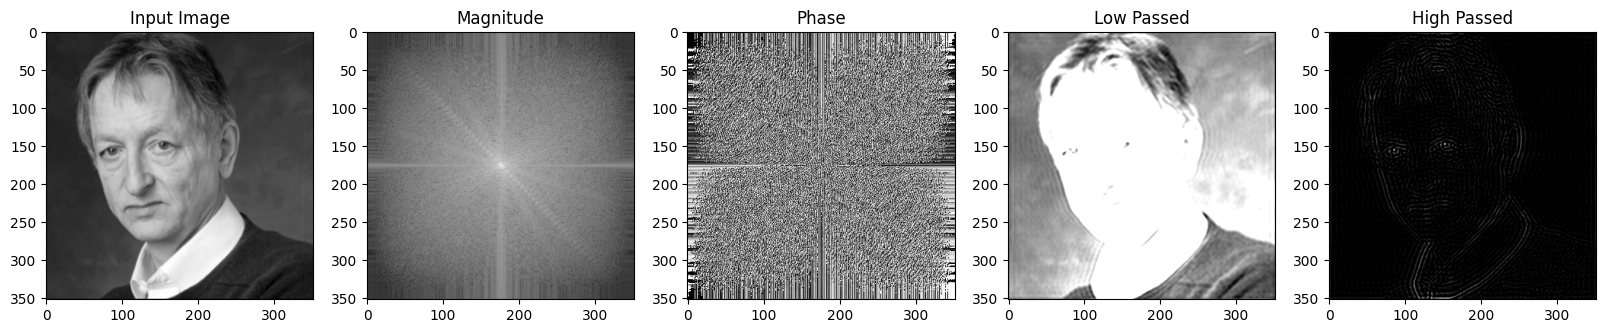

In [88]:
count = out1.shape[2]
col = 5
around = 100 // 2
for i in range(count):
    image = out1[:,:,i]
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude = 20*np.log(np.abs(fshift))
    phase = np.angle(fshift)
    
    low_pass = np.zeros((image.shape[0], image.shape[1]))
    high_pass = np.ones((image.shape[0], image.shape[1]))
    for j in range(low_pass.shape[0]):
        for k in range(low_pass.shape[1]):
            if j >= low_pass.shape[0] // 2 - around and j <= low_pass.shape[0] // 2 + around and k >= low_pass.shape[1] // 2 - around and k <= low_pass.shape[1] // 2 + around:
                low_pass[j, k] = 1
                high_pass[j, k] = 0

    l_filtered=np.multiply(fshift, low_pass)
    h_filtered=np.multiply(fshift, high_pass)

    l_ifft2 = np.real(np.fft.ifft2(np.fft.ifftshift(l_filtered)))
    l_ifft2 = np.maximum(0, np.minimum(l_ifft2, 255))
    
    h_ifft2 = np.real(np.fft.ifft2(np.fft.ifftshift(h_filtered)))
    h_ifft2 = np.maximum(0, np.minimum(h_ifft2, 255))

    plt.figure(figsize=(20,20))
    plt.subplot(count, col, 1 + col*i)
    plt.imshow(image, cmap='gray')
    plt.title('Input Image')
    plt.subplot(count, col, 2 + col*i)
    plt.imshow(magnitude, cmap='gray')
    plt.title('Magnitude')
    plt.subplot(count, col, 3 + col*i)
    plt.imshow(phase, cmap='gray')
    plt.title('Phase')
    plt.subplot(count, col, 4 + col*i)
    plt.imshow(l_ifft2, cmap='gray')
    plt.title('Low Passed')
    plt.subplot(count, col, 5 + col*i)
    plt.imshow(h_ifft2, cmap='gray')
    plt.title('High Passed')
    plt.show()

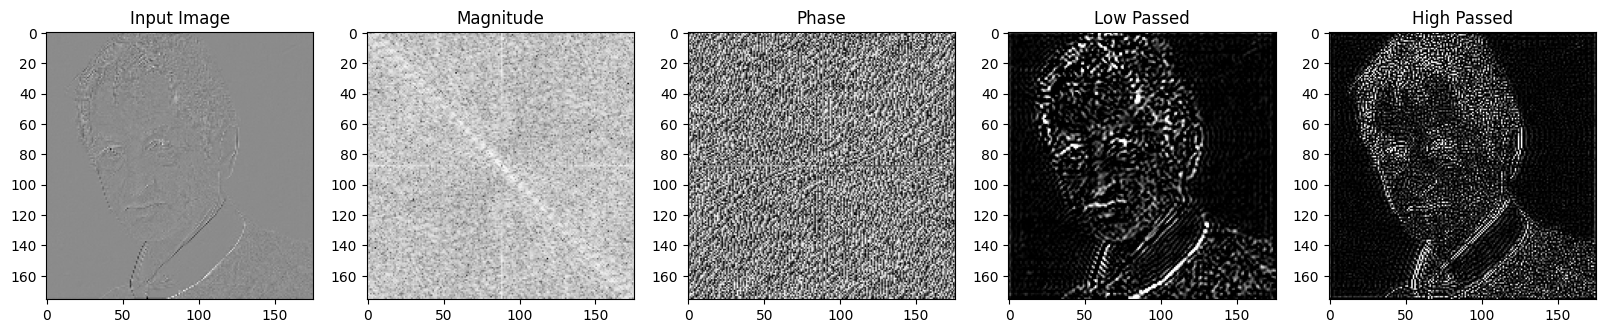

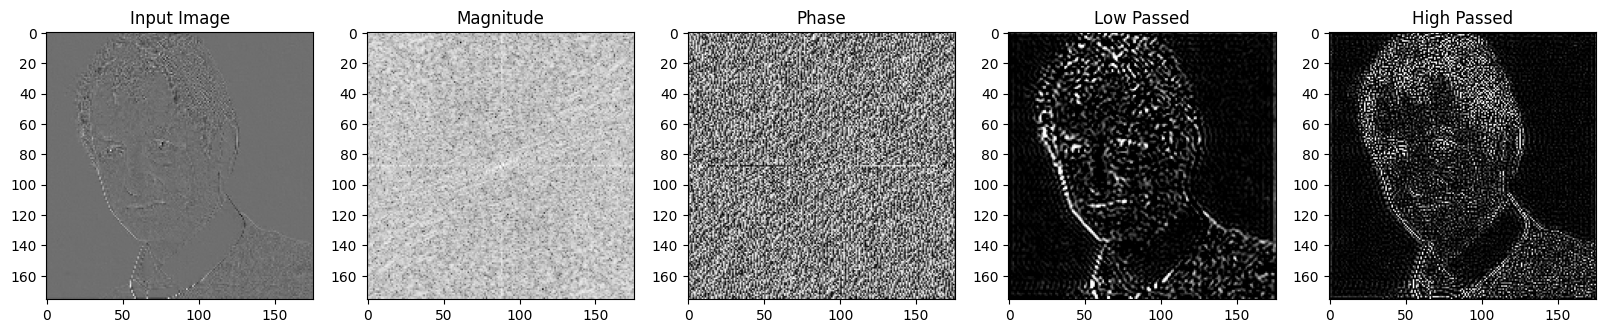

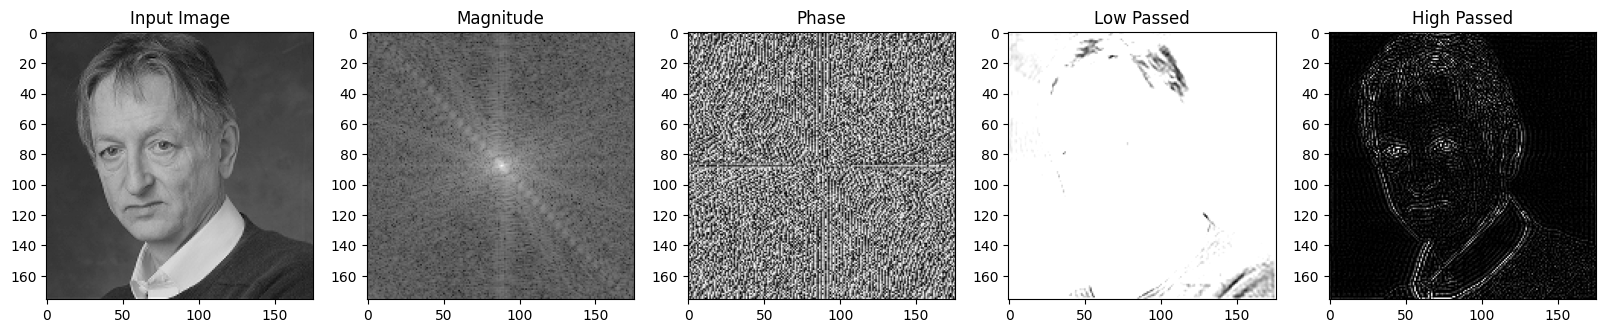

In [89]:
count = out2.shape[2]
for i in range(count):
    image = out2[:,:,i]
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude = 20*np.log(np.abs(fshift))
    phase = np.angle(fshift)
    
    low_pass = np.zeros((image.shape[0], image.shape[1]))
    high_pass = np.ones((image.shape[0], image.shape[1]))
    for j in range(low_pass.shape[0]):
        for k in range(low_pass.shape[1]):
            if j >= low_pass.shape[0] // 2 - around and j <= low_pass.shape[0] // 2 + around and k >= low_pass.shape[1] // 2 - around and k <= low_pass.shape[1] // 2 + around:
                low_pass[j, k] = 1
                high_pass[j, k] = 0

    l_filtered=np.multiply(fshift, low_pass)
    h_filtered=np.multiply(fshift, high_pass)

    l_ifft2 = np.real(np.fft.ifft2(np.fft.ifftshift(l_filtered)))
    l_ifft2 = np.maximum(0, np.minimum(l_ifft2, 255))
    
    h_ifft2 = np.real(np.fft.ifft2(np.fft.ifftshift(h_filtered)))
    h_ifft2 = np.maximum(0, np.minimum(h_ifft2, 255))

    plt.figure(figsize=(20,20))
    plt.subplot(count, col, 1 + col*i)
    plt.imshow(image, cmap='gray')
    plt.title('Input Image')
    plt.subplot(count, col, 2 + col*i)
    plt.imshow(magnitude, cmap='gray')
    plt.title('Magnitude')
    plt.subplot(count, col, 3 + col*i)
    plt.imshow(phase, cmap='gray')
    plt.title('Phase')
    plt.subplot(count, col, 4 + col*i)
    plt.imshow(l_ifft2, cmap='gray')
    plt.title('Low Passed')
    plt.subplot(count, col, 5 + col*i)
    plt.imshow(h_ifft2, cmap='gray')
    plt.title('High Passed')
    plt.show()

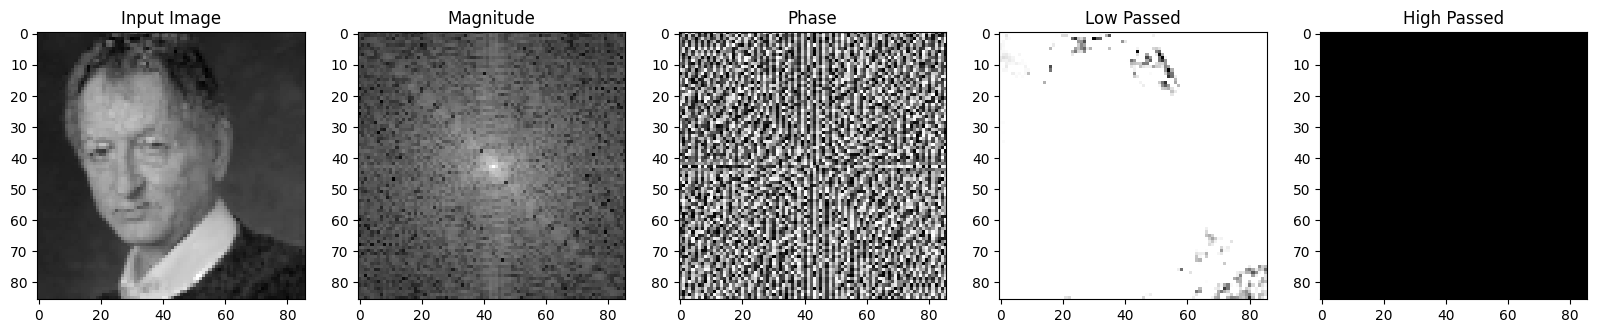

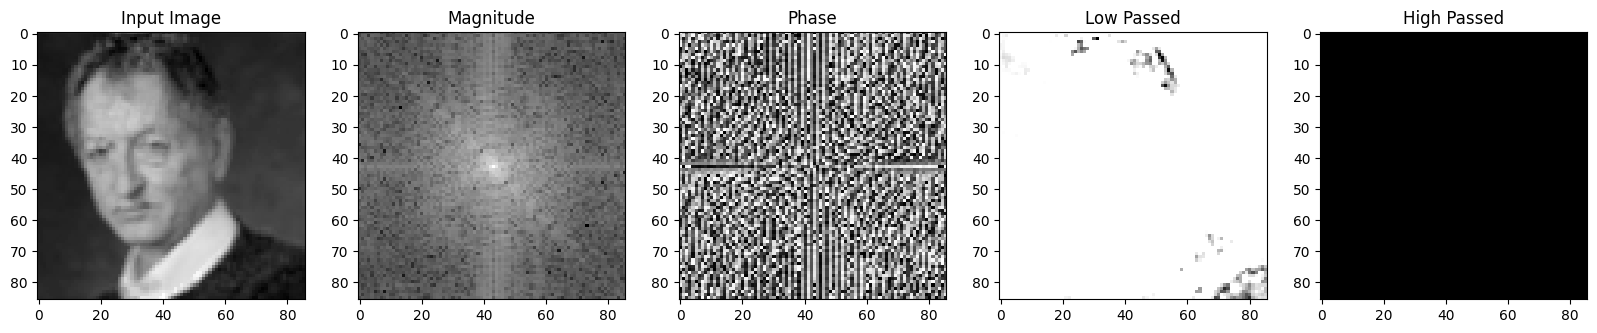

In [90]:
count = out3.shape[2]
for i in range(count):
    image = out3[:,:,i]
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude = 20*np.log(np.abs(fshift))
    phase = np.angle(fshift)
    
    low_pass = np.zeros((image.shape[0], image.shape[1]))
    high_pass = np.ones((image.shape[0], image.shape[1]))
    for j in range(low_pass.shape[0]):
        for k in range(low_pass.shape[1]):
            if j >= low_pass.shape[0] // 2 - around and j <= low_pass.shape[0] // 2 + around and k >= low_pass.shape[1] // 2 - around and k <= low_pass.shape[1] // 2 + around:
                low_pass[j, k] = 1
                high_pass[j, k] = 0

    l_filtered=np.multiply(fshift, low_pass)
    h_filtered=np.multiply(fshift, high_pass)

    l_ifft2 = np.real(np.fft.ifft2(np.fft.ifftshift(l_filtered)))
    l_ifft2 = np.maximum(0, np.minimum(l_ifft2, 255))
    
    h_ifft2 = np.real(np.fft.ifft2(np.fft.ifftshift(h_filtered)))
    h_ifft2 = np.maximum(0, np.minimum(h_ifft2, 255))

    plt.figure(figsize=(20,20))
    plt.subplot(count, col, 1 + col*i)
    plt.imshow(image, cmap='gray')
    plt.title('Input Image')
    plt.subplot(count, col, 2 + col*i)
    plt.imshow(magnitude, cmap='gray')
    plt.title('Magnitude')
    plt.subplot(count, col, 3 + col*i)
    plt.imshow(phase, cmap='gray')
    plt.title('Phase')
    plt.subplot(count, col, 4 + col*i)
    plt.imshow(l_ifft2, cmap='gray')
    plt.title('Low Passed')
    plt.subplot(count, col, 5 + col*i)
    plt.imshow(h_ifft2, cmap='gray')
    plt.title('High Passed')
    plt.show()